In [164]:
import random
import matplotlib.pyplot as plt
import numpy as np
try:
    from docplex.mp.model import Model
except:
    raise Exception('Installez docplex !pip install docplex')
from scipy.spatial import distance

In [165]:
capacité = 50 # capacité de la camionnette du marchand de poisson
nclients = 6 # nombre de clients 
nmagasins = 2 # nombre d'emplacements possibles pour les dépôts
lbdemande = 5 # borne inférieure pour la quantité demandée par les clients
ubdemande = 25 # borne supérieure pour la quantité demandée par les clients

In [166]:
# fixer le seed du random pour toujours avoir les mêmes données 
random.seed(17)
# génération des coordonnées aléatoires des clients  
clients = [(random.randint(0,30),random.randint(0,30)) for _ in range(nclients)]
# génération des coordonnées aléatoires des magasins 
magasins = [(random.randint(0,30), random.randint(0,30)) for _ in range(nmagasins)] 

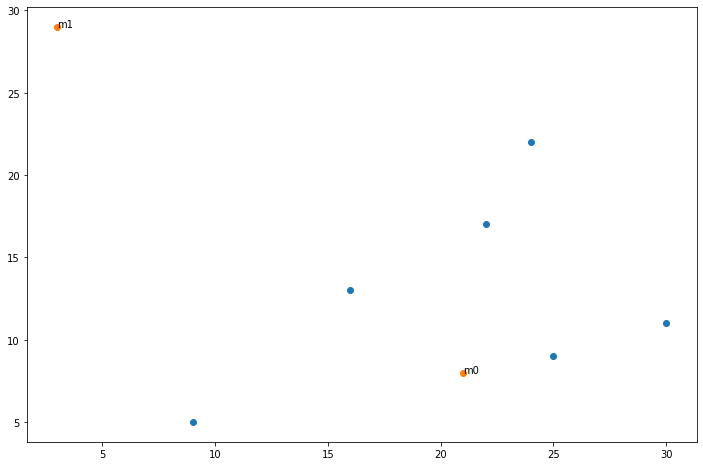

In [167]:
fig, ax = plt.subplots(figsize = (12,8))
# clients axe x et axe y
xclients, yclients = [client[0] for client in clients], [client[1] for client in clients]
# magasin axe x et axe y
xmagasins, ymagasins = [magasin[0] for magasin in magasins], [magasin[1] for magasin in magasins]
ax.scatter(xclients, yclients) 
ax.scatter(xmagasins, ymagasins)
for i in range(nmagasins):
    ax.annotate(f'm{i}', (xmagasins[i],ymagasins[i]))
plt.show()

In [168]:
def ModelInit(arcs, capacité, demandes, distances, N, magasins):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u') # ub = upperbound = capacité camionnette
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont pris
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) # graphe connexe, tous les arcs doivent être liés
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if ((i not in (magasins)) and (j not in (magasins))))
    model.add_constraints(u[i] >= demandes[i] for i in N)
    # model.parameters.timelimit = 60
    return model
  

In [169]:
def solver(model):
    return model.solve(clean_before_solve=True, log_output = False)

In [170]:
import itertools

# On veut chercher le meilleur chemin avec n magasins, il suffit de résoudre le problème indépendamment 
best_value = 10**10
best_magasin = None
best_solution = None

# Comme il suffit de calculer indépemment chaque sous problème et de garder le meilleur, on peut
# pré-calculer toutes les combinaisons possibles de magasins et tester avec chaque combinaison pour
# voir combien de dépôts il faut idéalement 
combi = set()
for k in range(1,nmagasins+1):
    for j in itertools.combinations(list(range(nmagasins)),k):
        combi.add(j)


for c in (combi):
    # Magasins testés pour cette itération 
    magasins = list(c)
    # Clients
    N = [int(i) for i in range(c[-1]+1, nclients+c[-1]+1)]
    # Définition du graphe
    V = magasins + N
    # Demandes
    demandes = {i:random.randint(lbdemande,ubdemande) for i in N}
    # Axe x et y pour les magasins + les clients
    xtot, ytot = dict({str(x): xmagasins[x] for x in magasins},**{str(y):x for x,y in zip(xclients, N)}), dict({str(x): ymagasins[x] for x in magasins},**{str(y):x for x,y in zip(yclients, N)})
    # Arcs du graphe 
    arcs = [(i,j) for i in V for j in V if ((i not in magasins or j not in magasins) and i != j)]
    # Calcul des distances entre les noeuds du graphe
    dists = {(i,j): np.hypot(xtot[str(i)]-xtot[str(j)],ytot[str(i)]-ytot[str(j)]) for i,j in arcs}
    # Initialisation du modèle
    model = ModelInit(arcs, capacité, demandes, dists, N, magasins)
    # Lancement du solver
    solution = solver(model)
    value = solution.objective_value
    if value < best_value:
        best_value = value 
        best_magasin = list(c)
        best_solution = solution
    model.clear()
print(f'La plus petite distance à parcourir est {best_value}')
print(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')

75.62200596082322
137.13582512242732
73.42877312892011
La plus petite distance à parcourir est 73.42877312892011
Le numéro du meilleur emplacement pour le magasin est [0, 1]
